# Modelos usando el algoritmo de redes neuronales

# Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import preprocessing
import informe
import sklearn
from sklearn.model_selection import train_test_split
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

# Modelo 1: red simple

## Llamado a funciones de preprocesamiento

In [117]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encodding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Red neuronal

In [126]:
mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model1 = Sequential()
model1.add(Dense(8, input_shape=(40,), activation='tanh'))
model1.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model1.summary()
history = model1.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 8)                 328       
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

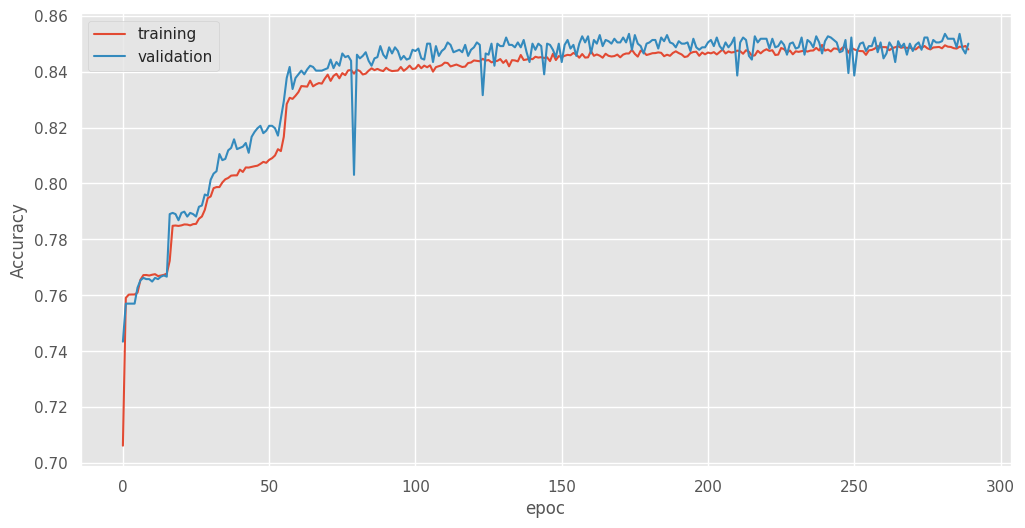

In [127]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Al ser una red simple, con relativamente pocos hiperparámetros, no hizo falta usar regularización. Se ve que no hay overfitting.

## Métricas


Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8458388780837343 
Precision: 0.6977818853974121 
Recall: 0.911705143782908 
F1-score: 0.6672558550596552 

Curva ROC-AUC:


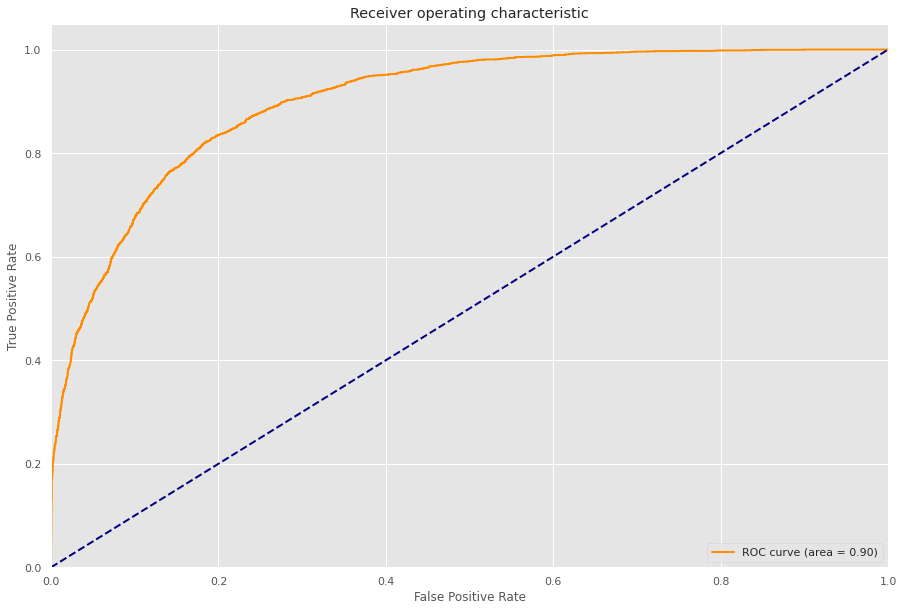

In [128]:
from sklearn.metrics import plot_roc_curve

y_proba = model1.predict(X_test)
y_pred = model1.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC-AUC:")
informe.plot_roc(model1, X_test, y_test, classifier=False, y_proba=y_proba)

# Modelo 2: red simple con datos numéricos escalados

## Llamado a funciones de preprocesamiento

In [27]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encodding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, scalar = preprocessing.escalar(X_train)
X_test, scalar = preprocessing.escalar(X_test, scalar)

## Red neuronal

In [91]:
from keras.regularizers import l2

mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=30, mode='max')

model2 = Sequential()
model2.add(Dense(8, input_shape=(40,), activation='tanh', kernel_regularizer=l2(0.0005)))
model2.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()
history = model2.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 8)                 328       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

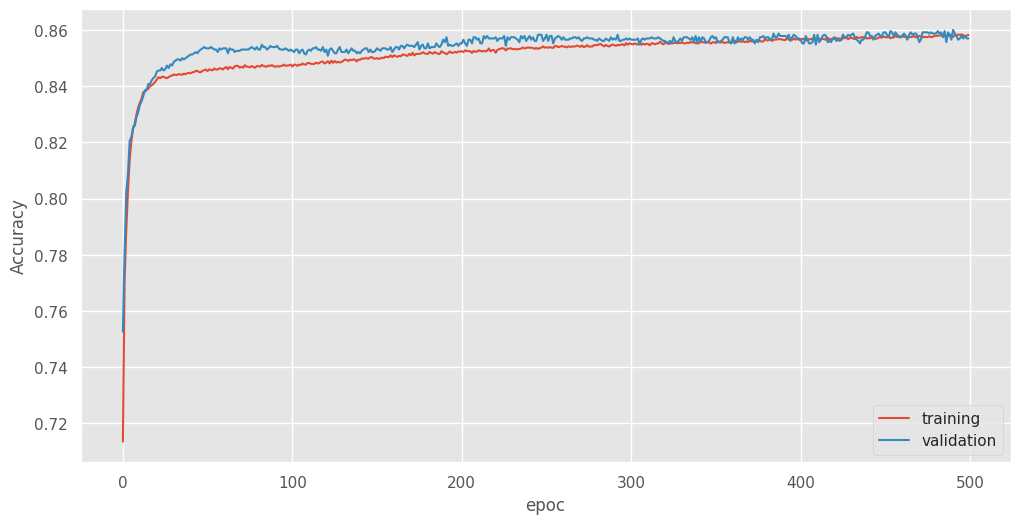

In [94]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Se ve que al usar los datos escalados el aprendizaje es menos errático, con menos saltos en el gráfico. Fue necesario usar regularización para evitar overfitting.

## Métricas


Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8517760262053434 
Precision: 0.7264618434093162 
Recall: 0.9254759011745646 
F1-score: 0.669406392694064 

Curva ROC-AUC:


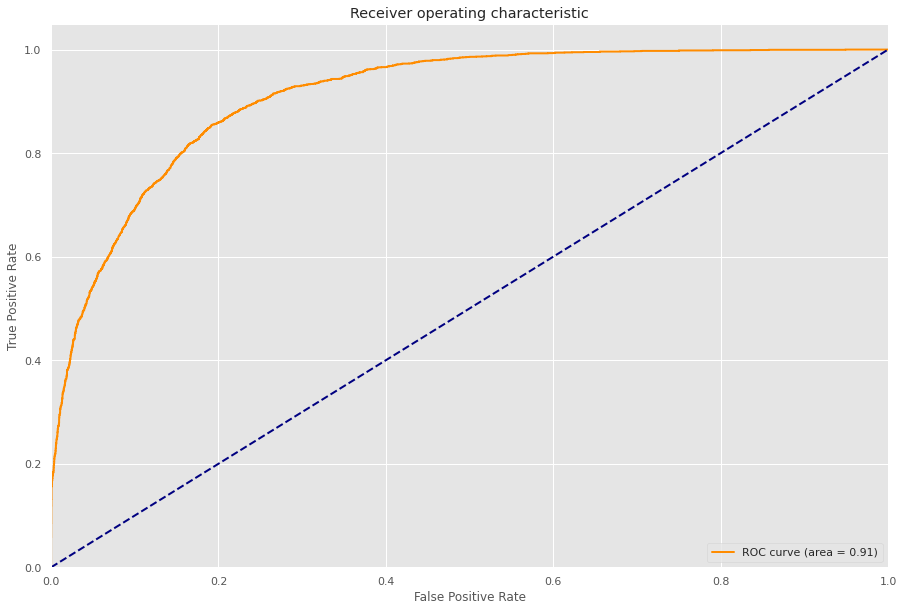

In [93]:
from sklearn.metrics import plot_roc_curve

y_proba = model2.predict(X_test)
y_pred = model2.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC-AUC:")
informe.plot_roc(model2, X_test, y_test, classifier=False, y_proba=y_proba)

# Modelo 3: red con dos capas y activación relu

## Llamado a funciones de preprocesamiento

In [131]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encodding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, scalar = preprocessing.escalar(X_train)
X_test, scalar = preprocessing.escalar(X_test, scalar)

## Red neuronal

In [138]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=30, mode='max')

model2 = Sequential()
model2.add(Dense(8, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.0005)))
model2.add(Dense(10, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.0005)))
model2.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()
history = model2.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 8)                 328       
_________________________________________________________________
dense_102 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 11        
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


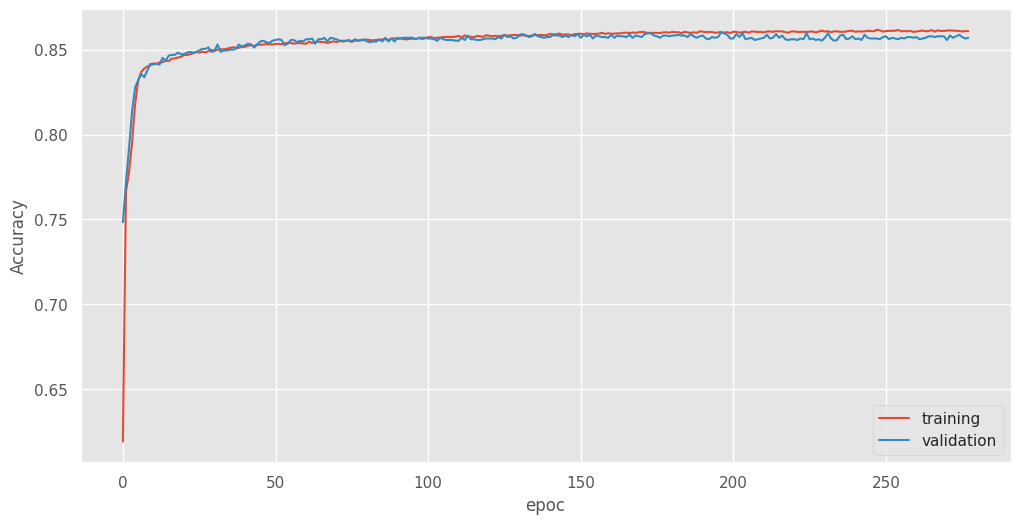

In [139]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Al aumentar la cantidad de capas se ve que hay una mayor diferencia en la evolución del training y validation, aunque con el correr de los epocs se igualan, sin llegar a overfittear.

## Métricas


Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8558706111167981 
Precision: 0.7345132743362832 
Recall: 0.9270959902794653 
F1-score: 0.6797088262056414 

Curva ROC-AUC:


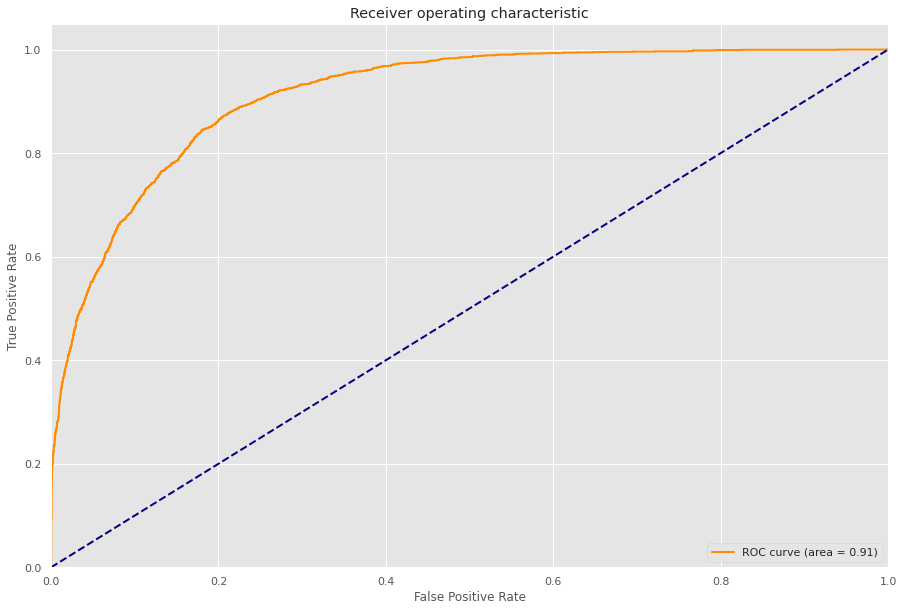

In [140]:
from sklearn.metrics import plot_roc_curve

y_proba = model2.predict(X_test)
y_pred = model2.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC-AUC:")
informe.plot_roc(model2, X_test, y_test, classifier=False, y_proba=y_proba)

# Modelo 3: red compleja

## Llamado a funciones de preprocesamiento

In [27]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encodding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, scalar = preprocessing.escalar(X_train)
X_test, scalar = preprocessing.escalar(X_test, scalar)

## Red neuronal

Se entrena una red más profunda, usando regularización para evitar el overfitting.

In [111]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model2 = Sequential()
model2.add(Dense(50, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()
history = model2.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 50)                2050      
_________________________________________________________________
dense_84 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 101       
Total params: 7,251
Trainable params: 7,251
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

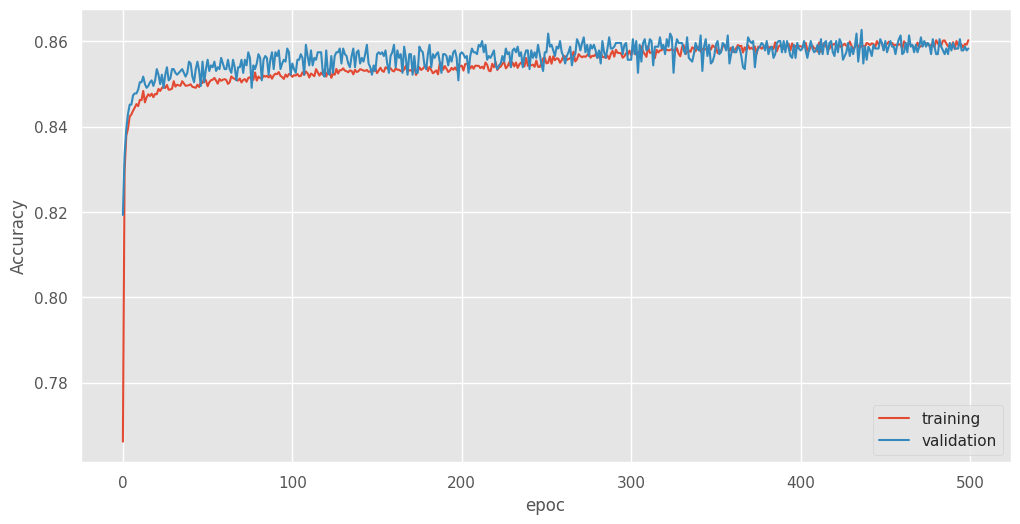

In [115]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Debido a la cantidad de hiperparámetros de la red, la tendencia a overfittear fue mayor y hubo que reforzar la regularización. Se ve cómo la performance en los datos de entrenamiento mejoran, mientras que la performance en los datos de validación están más estancados.

## Métricas


Se calcularon las métricas para la red 

Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8550516941345071 
Precision: 0.7330049261083744 
Recall: 0.9268259754286485 
F1-score: 0.6775956284153005 

Curva ROC-AUC:


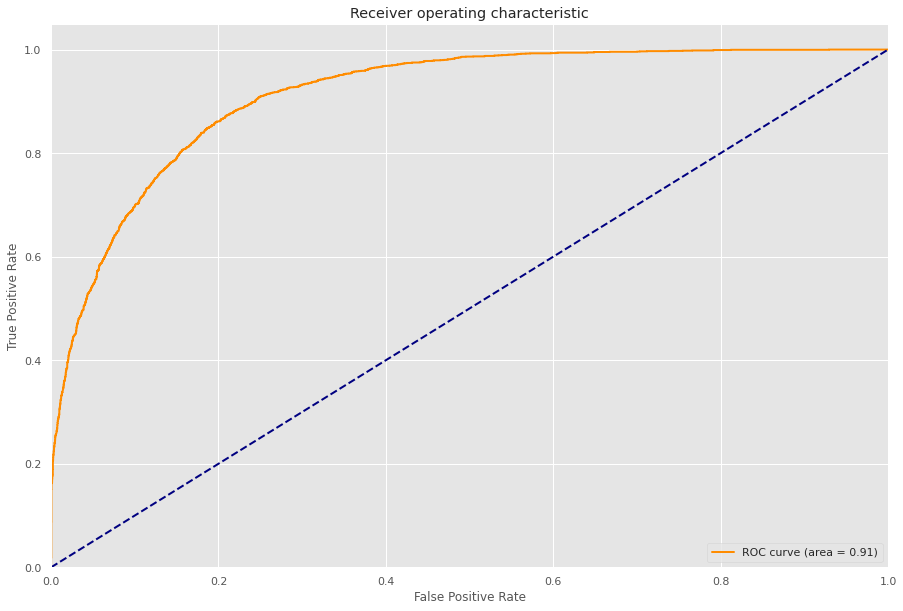

In [113]:
from sklearn.metrics import plot_roc_curve

y_proba = model2.predict(X_test)
y_pred = model2.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC-AUC:")
informe.plot_roc(model2, X_test, y_test, classifier=False, y_proba=y_proba)

# Conclusión
      
### Informe del modelo 2 usando los datos del test_holdout

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


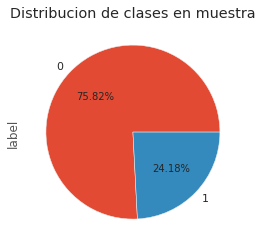

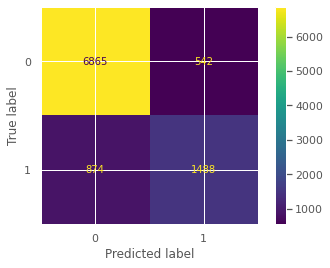

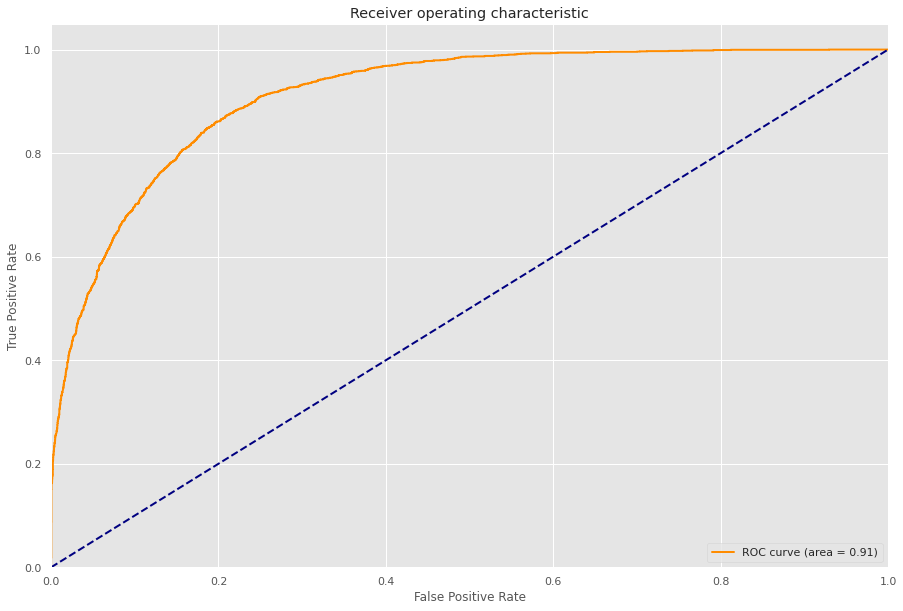

Métricas:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7407
           1       0.73      0.63      0.68      2362

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769



In [116]:
y_pred = model2.predict_classes(X_test)

informe.plt_distribucion_de_clases(y_test)
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, y_pred)).plot()
informe.plot_roc(model2, X_test, y_test, classifier=False, y_proba=y_proba)
print('Métricas:')
print(sklearn.metrics.classification_report(y_test, y_pred))

## Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 84%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        La fracción de predicciones de 0's que realmente eran 0's fue de aproximadamente 88% y la fracción de predicciones de 1's que realmente eran 1's fue del 71% 


- recall:

        Los 0's reales detectados fueron aproximadamente del 92%, y los 1's reales detectados fueron del 60%. Se ve que el modelo tiene un buen recall y precisión.
        

- f1 score:
   
       Este resultado da una idea de la calidad del recall y la precision asi como el balance entre ellos.
       
       
- matriz de confusion:

        Se puede ver que la cantidad de falsos negativos y falsos positivos fue similar. Sin embargo, la mayoría de las predicciones están en la diagonal.
        
        
- UAC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases en un 90%. Este valor será utilizado para decidir sobre la elección de este modelo.


# Final test

In [8]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.one_hot_encodding(df_test)
df_test, _ = preprocessing.escalar(df_test, scalar)

y_pred = model2.predict_classes(df_test)
informe.save_pred(y_pred, 'red_neuronal')

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
